In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import get_data
import statsmodels
from simulate import cholesky
from simulate import simulatedata
from simulate import simulate_multiple_time_series

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
syms = ['BTCUSDT']
freq = '10min'
start_date = '2020-01-01'
end_date = '2020-01-03'

In [39]:
raw_data = get_data.get_data(syms, freq, start_date, end_date)
raw_data

BTCUSDT_2019-12-26.json
BTCUSDT_2020-01-02.json


e:\trade\crypto\Binance\get_data.py:52: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  data[symbol] = _fit_data_to_df(data[symbol], frequency)[start_time:end_time]


{'BTCUSDT':                               open     high      low    close      volume  \
 time                                                                        
 2020-01-01 00:00:00+00:00  7195.24  7196.25  7178.20  7191.07  154.874358   
 2020-01-01 00:10:00+00:00  7193.15  7193.53  7177.35  7178.29   80.261439   
 2020-01-01 00:20:00+00:00  7177.71  7185.56  7175.47  7178.45   96.049725   
 2020-01-01 00:30:00+00:00  7178.19  7185.44  7176.23  7177.53   59.973326   
 2020-01-01 00:40:00+00:00  7177.14  7182.99  7176.34  7182.94   44.872982   
 ...                            ...      ...      ...      ...         ...   
 2020-01-02 23:20:00+00:00  6959.16  6962.39  6950.00  6962.34  217.262815   
 2020-01-02 23:30:00+00:00  6962.47  6974.75  6957.66  6965.37  145.757951   
 2020-01-02 23:40:00+00:00  6965.09  6969.46  6959.87  6967.41   75.157310   
 2020-01-02 23:50:00+00:00  6967.40  6968.82  6961.24  6965.71   82.459841   
 2020-01-03 00:00:00+00:00  6965.49  6965.71  6948.45

In [105]:
dt = pd.DataFrame()
dt['close'] = raw_data['BTCUSDT']['close']
dt['high'] = raw_data['BTCUSDT']['high']
dt['low'] = raw_data['BTCUSDT']['low']
dt['open'] = raw_data['BTCUSDT']['open']
# dt['close-open'] = raw_data['BTCUSDT']['close']/raw_data['BTCUSDT']['open']
dt.iloc[150]

close    7202.09
high     7211.16
low      7201.58
open     7211.04
Name: 2020-01-02 01:00:00+00:00, dtype: float64

In [106]:
dt1 = pd.DataFrame()
dt1['open'] = dt['open'].pct_change()
dt1['close'] = dt['close'].pct_change()
dt1 

,open,close
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.000290,-0.001777
2020-01-01 00:20:00+00:00,-0.002146,0.000022
2020-01-01 00:30:00+00:00,0.000067,-0.000128
2020-01-01 00:40:00+00:00,-0.000146,0.000754
...,...,...
2020-01-02 23:20:00+00:00,-0.001664,0.000457
2020-01-02 23:30:00+00:00,0.000476,0.000435
2020-01-02 23:40:00+00:00,0.000376,0.000293


In [113]:
var_close = simulate_multiple_time_series.compute_std(dt1['close'])
mean_close = dt1['close'].mean()
var_open = simulate_multiple_time_series.compute_std(dt1['open'])
mean_open = dt1['open'].mean()


# dt1.corr bị thành null matrix nên lúc trước tôi để thành dt để test và dt thì nó hiển nhiên ko đúng but ko biết làm 
# thế nào để fix cho cái dt1 nó ko bị null mặc dù cho chạy thẳng hàm cholesky.cholesky2 thì cũng có đoạn tính corr dt1 mà nó ko bị null
cov_open_close = dt1.corr()
cov = cov_open_close[0][0] / var_close * var_open
cov, var_open

KeyError: 0

In [110]:
data1 = []
data1 = np.append(data1, simulate_multiple_time_series.normalize_or_standardize_data(dt1['open'], is_normalize= False))
data2 = pd.DataFrame()
data2['close'] = dt1['close']-mean_close
for i in range(len(data2['close'])):
    data2['close'][i] = data2['close'][i] * 2 * cov_open_close[0][0] * var_open/var_close
data3 = pd.DataFrame()
data3['open'] = dt1['open']
data3['close'] = -data2['close']+ dt1['open']
chol = np.linalg.cholesky(data3.corr())
inverse_chol = np.linalg.inv(chol)
data1 = np.append(data1, data3['close'])
data1 = data1.reshape(2, len(dt1['close']))
data1 = np.matmul(inverse_chol, data1)
transform = pd.DataFrame(dt1).copy()
transform['close'] = data1[1]
transform['open'] = data1[0]
transform, simulate_multiple_time_series.compute_std(transform['close']),simulate_multiple_time_series.compute_std(transform['open'])

(                               open     close
 time                                         
 2020-01-01 00:00:00+00:00       NaN       NaN
 2020-01-01 00:10:00+00:00 -0.127426  0.052841
 2020-01-01 00:20:00+00:00 -1.450286  0.200032
 2020-01-01 00:30:00+00:00  0.127268 -0.017554
 2020-01-01 00:40:00+00:00 -0.024653 -0.014882
 ...                             ...       ...
 2020-01-02 23:20:00+00:00 -1.106465  0.142758
 2020-01-02 23:30:00+00:00  0.418607 -0.070197
 2020-01-02 23:40:00+00:00  0.347811 -0.057290
 2020-01-02 23:50:00+00:00  0.315988 -0.041522
 2020-01-03 00:00:00+00:00 -0.115783  0.020806
 
 [289 rows x 2 columns],
 0.14032550883824135,
 1.0)

In [56]:
order_close, seasonal_order_close = simulatedata.get_order(transform['close'][1:])
order_open, seasonal_order_open = simulatedata.get_order(transform['open'][1:])
order_close, seasonal_order_close, order_open, seasonal_order_open

((2, 0, 4), (0, 0, 0, 1), (2, 0, 0), (0, 0, 0, 1))

In [57]:
if sum(seasonal_order_close) == 1: seasonal_order_close = (0, 0, 0, 0)
model_params_close = simulatedata.fit_sarima(transform['close'][1:], order_close, seasonal_order_close)
if sum(seasonal_order_open) == 1: seasonal_order_open = (0, 0, 0, 0)
model_params_open = simulatedata.fit_sarima(transform['open'][1:], order_open, seasonal_order_open)

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [76]:
t_close = simulatedata.simulate_sarima(transform['close'][1:], order_close, seasonal_order_close, model_params_close, len(dt1), 1)
t_open = simulatedata.simulate_sarima(transform['open'][1:], order_open, seasonal_order_open, model_params_open, len(dt1), 1)
t_open, t_close

(            0
 0    2.343727
 1    0.549239
 2   -0.900713
 3    1.527301
 4    0.269735
 ..        ...
 284 -0.900866
 285  1.355842
 286 -0.622417
 287  0.442762
 288  0.313745
 
 [289 rows x 1 columns],
             0
 0   -0.026229
 1    0.160692
 2    0.056416
 3    0.459668
 4    0.045236
 ..        ...
 284 -0.047191
 285  0.028238
 286  0.030737
 287 -0.051362
 288 -0.145010
 
 [289 rows x 1 columns])

In [81]:
transform_x_chol = pd.DataFrame()
transform_x_chol['close'] = t_close[0]
transform_x_chol['open'] = t_open[0]
array = []
array = np.append(array, transform_x_chol['open'])
array = np.append(array, transform_x_chol['close'])
array = array.reshape(2,len(transform_x_chol['open']))
transform_back = np.matmul(chol, array)
# simulate_corr_rets['close'] = simulate_corr_rets['open'] - simulate_corr_rets['close']
simulate = pd.DataFrame()
simulate['open'] =simulate_multiple_time_series.mulback_cholesky(transform_back[0],  False, mean_open, var_open)
simulate['close'] = simulate_multiple_time_series.mulback_cholesky(transform_back[0] -transform_back[1],  False, mean_close, var_close/(2*cov))
# simulate ['close'] = simulate['open']-simulate['close']
simulate
# transform_back = simulate_multiple_time_series.transform_back(transform_x_chol, chol, var_close/(2*cov), mean_close, var_open, mean_open)
# transform_back

,open,close
0,0.003177,-0.011060
1,0.000659,-0.010458
2,-0.001375,0.002065
3,0.002031,-0.029684
4,0.000267,-0.003549
...,...,...
284,-0.001376,0.006950
285,0.001791,-0.008445
286,-0.000985,0.001815
287,0.000510,0.000098


In [82]:
simulate.corr()

,open,close
open,1.000000,-0.618155
close,-0.618155,1.000000


In [83]:
dt1.corr()

,open,close
open,1.000000,-0.093053
close,-0.093053,1.000000


In [84]:
simulated_price_data = pd.DataFrame()
simulated_price_data[0] = simulatedata.construct_price_series(simulate['open'], dt['open'][0], dt.index[0], freq)
simulated_price_data[1] = simulatedata.construct_price_series(simulate['close'], dt['close'][0], dt.index[0], freq)
# for i in range(len(simulated_price_data[1])):
#     simulated_price_data[1][i]=simulated_price_data[1][i] * simulated_price_data[0][i]
simulated_price_data

,0,1
2020-01-01 00:00:00+00:00,7195.240000,7191.070000
2020-01-01 00:10:00+00:00,7218.096684,7111.536016
2020-01-01 00:20:00+00:00,7222.852783,7037.164471
2020-01-01 00:30:00+00:00,7212.918345,7051.694309
2020-01-01 00:40:00+00:00,7227.568992,6842.374326
...,...,...
2020-01-02 23:20:00+00:00,7235.340988,5498.404276
2020-01-02 23:30:00+00:00,7225.387823,5536.617442
2020-01-02 23:40:00+00:00,7238.325631,5489.859503
2020-01-02 23:50:00+00:00,7231.196174,5499.825433


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by sett

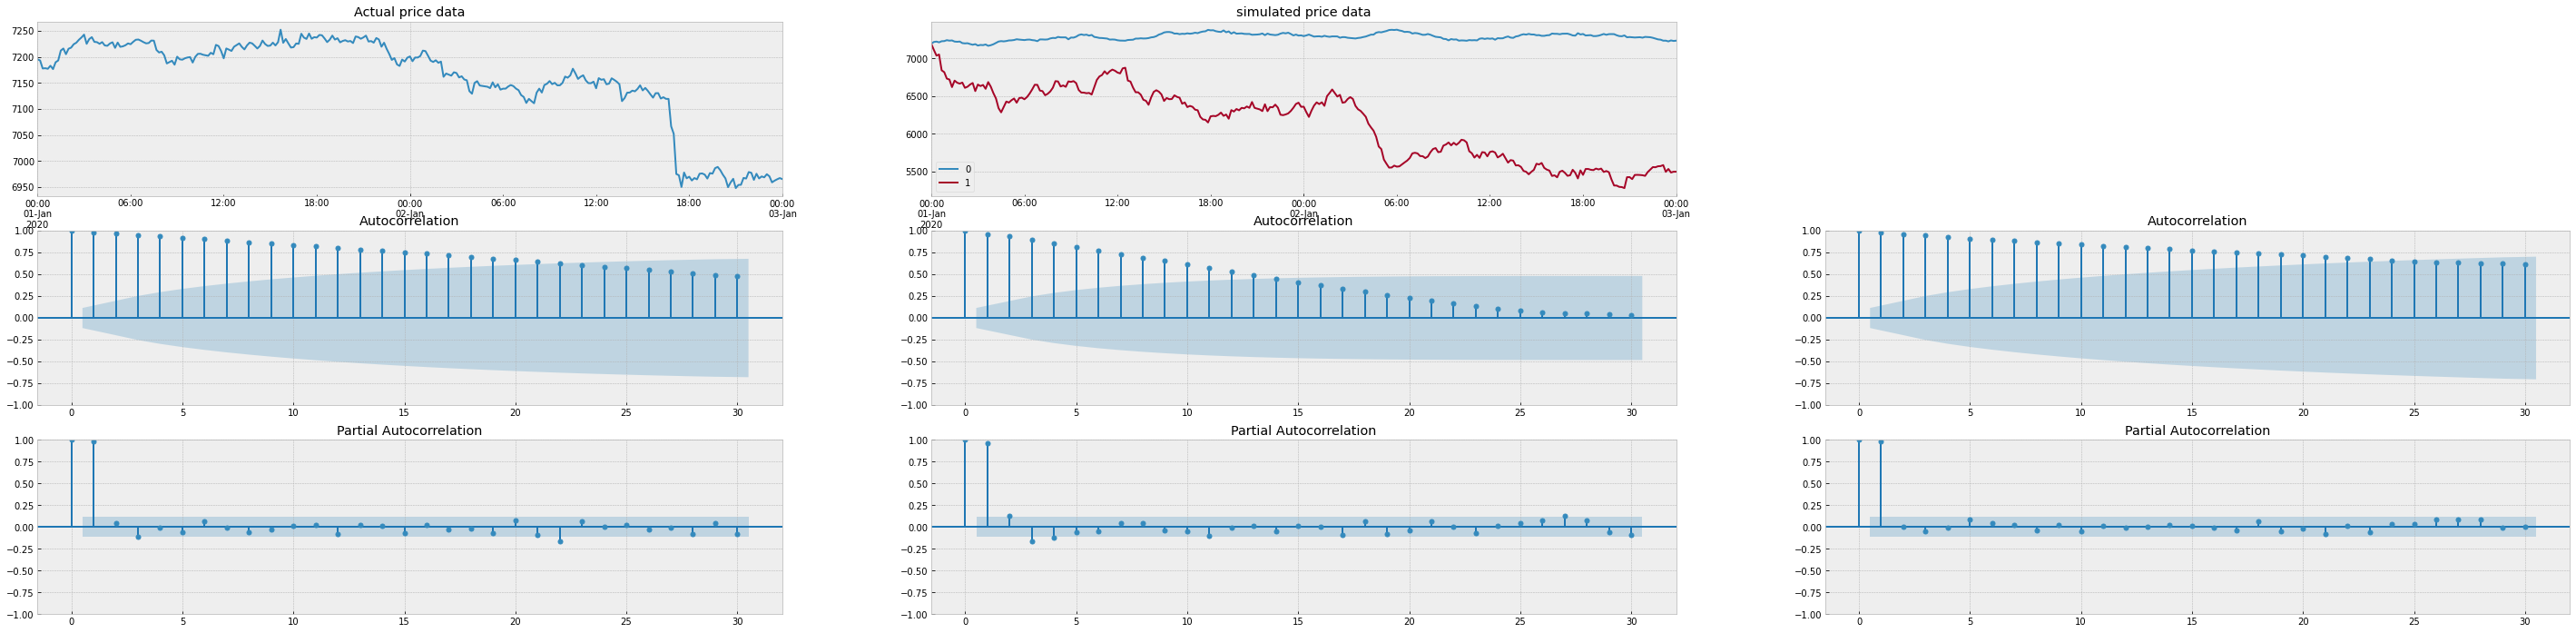

In [85]:
simulatedata.Evaluate_performance(dt['open'], simulated_price_data, lags=30)

In [ ]:
dt.plot()

In [ ]:
simulate_multiple_time_series.simulate_open_and_close(dt)

In [ ]:
# order, seasonal_order = simulatedata.get_order(dt['open'][1:])
# order, seasonal_order

In [ ]:
# if sum(seasonal_order) == 1: seasonal_order = (0, 0, 0, 0)
# model_params = simulatedata.fit_sarima(dt['open'][1:], order, seasonal_order)

In [ ]:
# t = simulatedata.simulate_sarima(dt['open'][1:], order, seasonal_order, model_params, len(dt), 10)
# t

In [ ]:
# simulated_price_data = simulatedata.construct_price_series(t, dt['close'][0], dt.index[0], freq)

In [ ]:
# simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)